# Generating OpenPose Annotations

For the task of enhancing pose estimation (PE) algorithms for vase-paintings we have decided to use the OpenPose PE model as a baseline.

One of the main advantages of OpenPose is that it is a one-stage algorithm that jointly computes the pose-skeletons
for all people in one image.  This advatange overcomes the problem of having a person detection preprocessing step
and makes the complexity of the model independent of the number of people in the image.

In order to detect several skeletons simultanously, the OpenPose algorithm uses two different types of annotations:
 - **Keypoint Heatmaps**: encode the position of each body joint in the image. They are represented as confidence maps in a 2D space.
     These confidence maps are optained by evaluating a (sort of) Gaussian kernel centered at the joint.

 - **Part Affinity Fields (PAFs)**: they encode the relationship and association between the different keypoints. They are the key element that allow
     the OpenPose algorithm to jointly estimate all pose-skeletons

In this notebook we test the library methods used to convert the standard COCO annotations to the **Keypoint Heatmaps** and **PAFs** necessary to train the models.

In [1]:
import os
import sys
import json

import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import pycocotools

sys.path.append("..")

from data import StyledCoco
from data.custom_transforms import Resize
from CONFIG import CONFIG

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
data_path = CONFIG["paths"]["data_path"]
images_path = os.path.join(data_path, "images", "train")
original_imgs_path = os.path.join(data_path, "original_images", "train2017")
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_train.json")

In [4]:
dataset = StyledCoco(root=images_path, annFile=labels_file, original_imgs_path=original_imgs_path,
                     transforms=transforms.Compose([
                                   Resize(size=400)
                     ]))

loading annotations into memory...
Done (t=23.25s)
creating index...
index created!


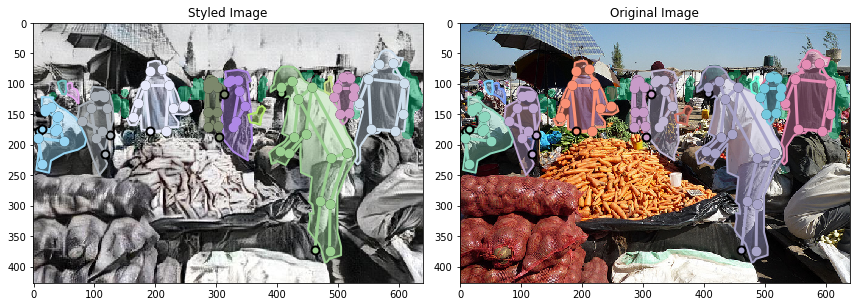

In [5]:
plt.figure(figsize=(12,6))
plt.axis('off')

# img, target = dataset.get_styled(7)
img, target = dataset.get_styled(0)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"Styled Image")
dataset.coco.showAnns(target)
    
# original_img, original_target = dataset.get_original(7)
original_img, original_target = dataset.get_original(0)
plt.subplot(1,2,2)
plt.imshow(original_img)
plt.title(f"Original Image")
dataset.coco.showAnns(original_target)
    
plt.tight_layout()
plt.show()

## Keypoint Heatmap Annotation

In [11]:
img, _, heatmaps, pafs, mask = dataset[0]

'generate_heatmaps'  1323.28 ms
'generate_paf'  2382.16 ms
'get_mask'  56.84 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


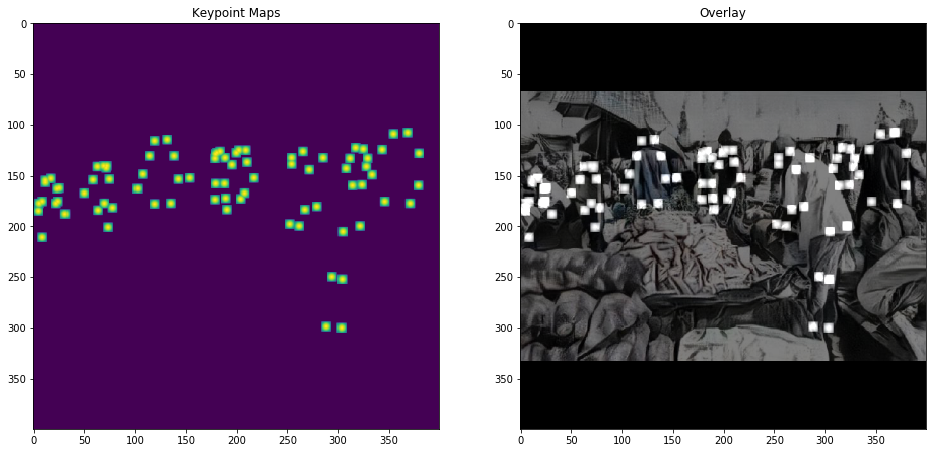

In [12]:
heatmap_vis = 1-heatmaps[-1,:]
img_vis = np.copy(img).transpose((1, 2, 0))
img_vis[:,:,:] = img_vis[:,:,:]*0.5
img_vis[:,:,0] = img_vis[:,:,0] + heatmap_vis*255
img_vis[:,:,1] = img_vis[:,:,1] + heatmap_vis*255
img_vis[:,:,2] = img_vis[:,:,2] + heatmap_vis*255
img_vis = np.round(img_vis).astype(int)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(heatmap_vis*255)
plt.title(f"Keypoint Maps")
plt.subplot(1,2,2)
plt.imshow(img_vis)
plt.title(f"Overlay")
plt.show()

## PAF Map Annotation

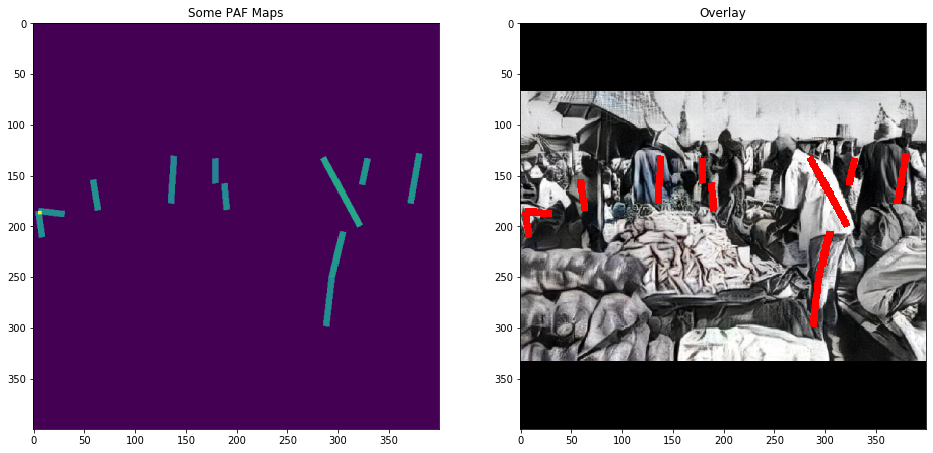

In [13]:
paf_vis_0 = pafs[0,:] + pafs[1,:] + pafs[6,:]
paf_vis_1 = pafs[-1,:]
img_vis = np.copy(img).transpose((1, 2, 0))
idx = np.argwhere(paf_vis_0>0)
img_vis[idx[:,0],idx[:,1],0] = 255
img_vis[idx[:,0],idx[:,1],1] = 0
img_vis[idx[:,0],idx[:,1],2] = 0
img_vis = np.clip(img_vis, 0, 255)
img_vis = np.round(img_vis).astype(int)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(paf_vis_0*10000)
plt.title(f"Some PAF Maps")
plt.subplot(1,2,2)
plt.imshow(img_vis)
plt.title(f"Overlay")
plt.show()

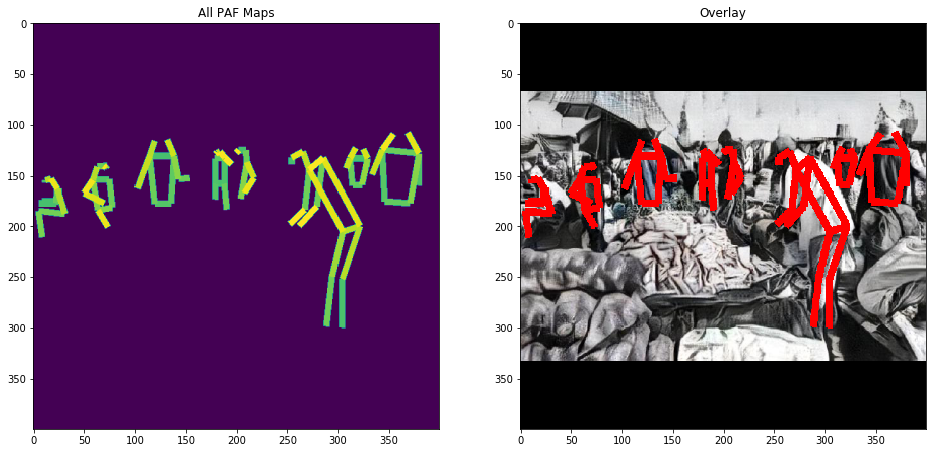

In [14]:
paf_vis_1 = pafs[-1,:]
img_vis = img.transpose((1, 2, 0))
idx = np.argwhere(paf_vis_1>0)
img_vis[idx[:,0],idx[:,1],0] = 255
img_vis[idx[:,0],idx[:,1],1] = 0
img_vis[idx[:,0],idx[:,1],2] = 0
img_vis = np.clip(img_vis, 0, 255)
img_vis = np.round(img_vis).astype(int)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(paf_vis_1*10000)
plt.title(f"All PAF Maps")
plt.subplot(1,2,2)
plt.imshow(img_vis)
plt.title(f"Overlay")
plt.show()

## Obtaining mask

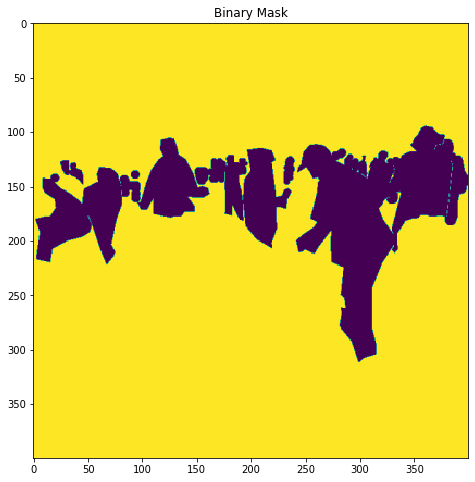

In [15]:
plt.figure(figsize=(8,8))
plt.imshow(mask[0,:])
plt.title("Binary Mask")
plt.show()

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 